# Dynamic mode decomposition with control on a high-dimensional, stable, linear system
Dynamic mode decomposition with control (DMDc) aims to disambiguate the effect of control/actuation
from the unforced dynamics.
We apply DMDc to a high-dimensional, stable, linear system
with intrinsic low-dimensional dynamics
(this is example 2 in Sec. 4 in Proctor et al., _"Dynamic Mode Decomposition with Control"_, SIAM 2016).

$$\hat{x}_{k+1} =A\hat{x}_k + B u$$

We first import the pyKoopman package and other packages for plotting and matrix manipulation.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm

import pykoopman as pk

Define state and control matrices of the linear control system and collect data.

(20, 100)


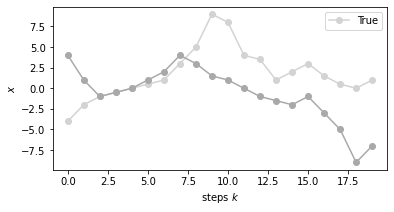

In [210]:
from scipy.linalg import orth

# Discrete, random, stable, linear state space model
def drss(n=2, p=2, m=2,
         p_int_first=0.1, p_int_others=0.01,
         p_repeat=0.05, p_complex=0.5):
    # Number of integrators
    nint = int((np.random.rand(1)<p_int_first)+sum(np.random.rand(n-1)<p_int_others));
    # Number of repeated roots
    nrepeated = int(np.floor(sum(np.random.rand(n-nint)<p_repeat)/2));
    # Number of complex roots
    ncomplex = int(np.floor(sum(np.random.rand(n-nint-2*nrepeated,1)<p_complex)/2));
    nreal = n-nint-2*nrepeated-2*ncomplex;

    # Random poles
    rep = 2*np.random.rand(nrepeated)-1;
    if ncomplex != 0:
        mag = np.random.rand(ncomplex);
        cplx = np.zeros(ncomplex,dtype=complex)
        for i in range(ncomplex):
            tmp = np.exp(complex(0,np.pi*np.random.rand(1)))
            cplx[i] = mag[i]*np.exp(complex(0,np.pi*np.random.rand(1)))
        re = np.real(cplx);
        im = np.imag(cplx);

    # Generate random state space model
    A = np.zeros((n,n))
    if ncomplex != 0:
        for i in range(0,ncomplex):
            A[2*i:2*i+2,2*i:2*i+2] = np.array([[re[i],im[i]],[-im[i],re[i]]])

    if 2*ncomplex<n:
        list_poles = []
        if nint:
            list_poles = np.append(list_poles, np.ones(nint))
        if rep:
            list_poles = np.append(list_poles, rep)
            list_poles = np.append(list_poles, rep)
        if nreal:
            list_poles = np.append(list_poles, 2*np.random.rand(nreal)-1)

        A[2*ncomplex:,2*ncomplex:] = np.diag(list_poles)

    T = orth(np.random.rand(n,n));
    A = (np.transpose(T)@(A@T))

    # control matrix
    B = np.random.randn(n,p)
    # mask for nonzero entries in B
    mask = np.random.rand(B.shape[0], B.shape[1])
    B = np.squeeze(np.multiply(B, [(mask<0.75) != 0]))

    # Measurement matrix
    C = np.random.randn(m,n)
    mask = np.random.rand(C.shape[0], C.shape[1])
    C = np.squeeze(C * [(mask<0.75) != 0])
    return A,B,C

def advance_linear_system(x0,u,n,A=None,B=None,C=None):
    y = np.zeros([n,C.shape[0]])
    x = np.zeros([n,len(x0)])
    x[0,:] = x0
    y[0,:] = C.dot(x[0,:])
    for i in range(n-1):
        x[i+1,:] = A.dot(x[i,:]) + B.dot(u[:,i])
        y[i+1,:] = C.dot(x[i+1,:])
    return x,y

A,B,C = drss(5,2,100)

x0 = np.array([4,7,2,8,0])
u = np.array([[-4, -2, -1, -0.5, 0, 0.5, 1, 3, 5, 9, 8, 4, 3.5, 1, 2, 3, 1.5, 0.5, 0, 1],
              [4, 1, -1, -0.5, 0, 1, 2, 4, 3, 1.5, 1, 0, -1, -1.5, -2, -1, -3, -5, -9, -7]])
n = u.shape[1]
x,y = advance_linear_system(x0,u,n,A,B,C)
X1 = y[:-1,:]
X2 = y[1:,:]
U = u
print(y.shape)

